# Compare shift fit and empirical percentiles methods in GCMs : SI

Apply empirical percentile and shift fit method on all GCMs (for shift fit: 1950-2019 data and corresponding model GMST, same as in reanalysis), and compare the resulting nAHD for WBGT28.

Sensitivity test to method for calculation of nAHD. 

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, statsmodels

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4

%matplotlib inline

#plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature



# import my variables settings functions from other scripts
from settings import *
from functions import *
from utils import *
from plotscript import *


sys.path.append('../dist_cov/dist_cov/')
from scipy.stats import norm
import distributions as distributions


In [2]:
cellarea = xr.open_dataarray(os.path.join(datadirs,'geo-information/clm45_area.nc4'))
figdir = os.path.join(figdirs, 'fig_feb25')


# Fxns

In [3]:
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec

def plot_map_nAHD(data_plot,
                    ax,
                    proj=ccrs.PlateCarree(),
                    vmin = -100,
                    vmax = 200, 
                    levels = np.linspace(-100, 200, 16),
                    title_label = None,
                  title=True, 
                  skew=True,
                  cmap = 'RdBu_r',
                  extend='both'
                  
            ):

    if skew:
        cmap = LinearSegmentedColormap.from_list('new_RdBu_r', plt.get_cmap('RdBu_r')(np.linspace(0.25, 1, 192))) 
        norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    else:
        cmap = cmap
    crs = ccrs.PlateCarree()
    ax.set_extent([-179.75, 179.75, -60, 90], crs=ccrs.PlateCarree())

    # plot
    plot = data_plot.plot(vmin=vmin, vmax=vmax, cmap=cmap, transform=crs, levels=levels, extend=extend, add_colorbar=False, ax=ax)
    ax.coastlines(color='black', linewidth=0.8)
    if title:
        try: 
            ax.set_title(f'{data_plot.dataset.values} \n{round(data_plot.min().values, 0)}, {round(data_plot.max().values,0)}, {round(data_plot.mean().values,0)}')
        except:
            ax.set_title(f'{data_plot.model.values} \n{data_plot.min().values.round(0)}, {data_plot.max().values.round(0)}, {data_plot.mean().values.round(0)}')
    else:
        ax.set_title('')
            
    ax.set_title(title_label, loc='left',fontweight='bold')

    return plot 

In [4]:
import numpy as np

def rmse_weighted(a, b, cellarea=cellarea, mask=True):
    """
    Calculates RMSE between a forecast, a, and an observation, b, 
    with area weighting using cellarea.
    """
    if mask:
        cellarea = cellarea * landmask
        a = a * landmask
        b = b * landmask 
    weighted_squared_errors = cellarea * (a - b) ** 2
    return np.sqrt(np.sum(weighted_squared_errors) / np.sum(cellarea))

def mae_weighted(a, b, cellarea=cellarea, mask=True):
    """
    Calculates mean absolute error between a and b, 
    with area weighting using cellarea.
    """
    if mask:
        cellarea = cellarea * landmask
        a = a * landmask
        b = b * landmask 
    weighted_absolute_errors = cellarea * np.abs(a - b)
    return np.sum(weighted_absolute_errors) / np.sum(cellarea)

def bias_weighted(a, b, cellarea=cellarea, mask=True):
    """
    Calculates mean bias between a and b, 
    with area weighting using cellarea.
    """
    if mask:
        cellarea = cellarea * landmask
        a = a * landmask
        b = b * landmask 
    weighted_errors = cellarea * (a - b)
    return np.sum(weighted_errors) / np.sum(cellarea)


In [5]:
def rmse(a,b):
    """
    calculates RMSE between a forecast, a, and an observation, b

    """
    return(np.sqrt(np.mean((a - b)**2)))

def mae(a, b):
    """
    Calculates mean absolute error between a and b, 
    """
    return np.mean(np.abs(a - b))

def bias(a, b):
    """
    Calculates mean absolute error between a and b, 
    """
    return np.mean(a - b)

def skewness(x):
    """
    Calculate skewness of x (1-D array).
    """
    return np.mean(((x - np.mean(x))/np.std(x))**3)

# 1) Calc nAHD (shift fit) from GCMs

In [6]:
flags['models']='ISIMIP3b'

model_years = calc_warming_periods_models(GCMs, dir_gmst_models, observed_warming_path, target_year=2023, method='ar6', match='closest', windowsize=0)[['year']]
model_years

year
model              
CanESM5        2009
CNRM-CM6-1     2025
GFDL-ESM4      2035
IPSL-CM6A-LR   2012
MIROC6         2038
MRI-ESM2-0     2024
EC-Earth3      2017
UKESM1-0-LL    2022
MPI-ESM1-2-HR  2024
CNRM-ESM2-1    2030

In [7]:

dirname = 'output_shift-fit' 
start_year=1950 
dir_shift_fit = 'forster2024-hitol-nan'

da_list = []

for i in range(len(GCMs)):
    GCM = GCMs[i]
    filepath = glob.glob(os.path.join('/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output', 
                                      f'output_shift-fit/{dir_shift_fit}/WBGT/ISIMIP3b/{GCM}/*_WBGT_params_shift_loc_mon_{start_year}_2019.nc'))[0]
    da = xr.open_dataarray(filepath).expand_dims("dataset").assign_coords(dataset=("dataset", [GCM]))
    da_list.append(da)
    
    da_params_mod = xr.concat(da_list, dim="dataset") #loc sigma long

In [8]:
da_params_mod

# plot b1 to compare with reanalysis

<xarray.DataArray 'fit_params' (dataset: 10, month: 12, lat: 360, lon: 720,
                                params: 3)>
array([[[[[-2.49495439e+01, -1.48788528e-01,  5.50431205e+00],
          [-2.49464177e+01, -1.62544655e-01,  5.51231098e+00],
          [-2.49111824e+01, -2.54900166e-01,  5.51338040e+00],
          ...,
          [-2.49424435e+01, -1.61727472e-01,  5.51187089e+00],
          [-2.48951176e+01, -2.71800819e-01,  5.51553799e+00],
          [-2.49002269e+01, -2.76439931e-01,  5.52299847e+00]],

         [[-2.62064202e+01,  1.59506695e+00,  5.59353930e+00],
          [-2.62116750e+01,  1.58327947e+00,  5.59022359e+00],
          [-2.61947629e+01,  1.53320707e+00,  5.59509524e+00],
          ...,
          [-2.61960200e+01,  1.57601237e+00,  5.60484772e+00],
          [-2.61606000e+01,  1.51249646e+00,  5.59961934e+00],
          [-2.61682188e+01,  1.52201227e+00,  5.61156215e+00]],

         [[-2.80240138e+01,  4.24847041e+00,  5.82878187e+00],
          [-2.80336099e+01,  4.25774125e+00,  5.82894115e+00],
          [-2.80249053e+01,  4.24946995e+00,  5.84480631e+00],
          ...,
...
          ...,
          [-2.90897799e+01,  1.25391182e+00,  2.96778916e+00],
          [-2.90810408e+01,  1.25123265e+00,  2.96541372e+00],
          [-2.90760265e+01,  1.25393690e+00,  2.97193890e+00]],

         [[-2.98247780e+01,  2.01730641e+00,  3.03147379e+00],
          [-2.98234018e+01,  2.02029360e+00,  3.02571728e+00],
          [-2.98099813e+01,  2.01662382e+00,  3.03117110e+00],
          ...,
          [-2.98486018e+01,  2.02079339e+00,  3.02911596e+00],
          [-2.98345994e+01,  2.01607679e+00,  3.03425128e+00],
          [-2.98308584e+01,  2.01777341e+00,  3.02648146e+00]],

         [[-2.91713019e+01,  6.33416266e-01,  3.06128507e+00],
          [-2.91699130e+01,  6.27534401e-01,  3.06300241e+00],
          [-2.91613319e+01,  6.36188337e-01,  3.06140488e+00],
          ...,
          [-2.91869426e+01,  6.26858758e-01,  3.06510796e+00],
          [-2.91768676e+01,  6.29320512e-01,  3.06381035e+00],
          [-2.91784647e+01,  6.27432459e-01,  3.06456049e+00]]]]])
Coordinates:
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) object 'b0' 'b1' 'sigma'
  * dataset  (dataset) <U13 'CanESM5' 'CNRM-CM6-1' ... 'CNRM-ESM2-1'

In [9]:
df_gmst_mod = merge_model_gmst(GCMs, dir_gmst_models)
df_gmst_mod_smo = df_gmst_mod.apply(lambda col: apply_lowess(col, df_gmst_mod.index, ntime=4))
df_gmst_mod_smo

CanESM5  CNRM-CM6-1  GFDL-ESM4  IPSL-CM6A-LR    MIROC6  MRI-ESM2-0  \
year                                                                        
1850  0.081839    0.075265  -0.116804     -0.163789 -0.073311    0.073341   
1851 -0.027388    0.041693  -0.073870     -0.071802 -0.082864    0.061162   
1852 -0.087118    0.024950  -0.009374     -0.008409 -0.066935    0.019337   
1853 -0.054830    0.025412  -0.004595      0.037362  0.026333   -0.047268   
1854 -0.061384    0.024409  -0.085900      0.065928  0.191804   -0.040739   
...        ...         ...        ...           ...       ...         ...   
2096  6.125161    4.733954   3.435702      5.299199  3.125304    3.779781   
2097  6.248846    4.811054   3.459183      5.345967  3.036804    3.785240   
2098  6.367561    4.867603   3.484327      5.373768  3.152982    3.818553   
2099  6.421602    4.949129   3.509874      5.356710  3.355424    3.849380   
2100  6.440541    5.023127   3.525024      5.404297  3.627774    4.007493   

      EC-Earth3  UKESM1-0-LL  MPI-ESM1-2-HR  CNRM-ESM2-1  
year                                                      
1850  -0.082681    -0.062625      -0.005754     0.124842  
1851   0.002303    -0.021973       0.078604     0.188433  
1852  -0.004756     0.035597       0.199157     0.173887  
1853  -0.075239     0.064067       0.104657     0.095709  
1854  -0.128356     0.021006       0.010157    -0.000254  
...         ...          ...            ...          ...  
2096   4.628006     5.891278       3.618147     4.389936  
2097   4.909858     5.991796       3.622728     4.476962  
2098   4.805906     6.082378       3.681728     4.505526  
2099   4.701958     6.166923       3.754057     4.531406  
2100   4.751033     6.296467       3.813415     4.555685  

[251 rows x 10 columns]

In [10]:
da_gmst_mod_smo = xr.DataArray(df_gmst_mod_smo, dims=["year", "dataset"])
da_gmst_mod_smo

<xarray.DataArray (year: 251, dataset: 10)>
array([[ 8.18385606e-02,  7.52653566e-02, -1.16803937e-01, ...,
        -6.26250237e-02, -5.75406827e-03,  1.24841837e-01],
       [-2.73882100e-02,  4.16930991e-02, -7.38702660e-02, ...,
        -2.19726135e-02,  7.86039936e-02,  1.88432923e-01],
       [-8.71176935e-02,  2.49502816e-02, -9.37445239e-03, ...,
         3.55972060e-02,  1.99156863e-01,  1.73886868e-01],
       ...,
       [ 6.36756093e+00,  4.86760265e+00,  3.48432657e+00, ...,
         6.08237760e+00,  3.68172836e+00,  4.50552561e+00],
       [ 6.42160200e+00,  4.94912916e+00,  3.50987447e+00, ...,
         6.16692271e+00,  3.75405663e+00,  4.53140591e+00],
       [ 6.44054136e+00,  5.02312720e+00,  3.52502444e+00, ...,
         6.29646687e+00,  3.81341471e+00,  4.55568526e+00]])
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
  * dataset  (dataset) object 'CanESM5' 'CNRM-CM6-1' ... 'CNRM-ESM2-1'

In [11]:
model_years

year
model              
CanESM5        2009
CNRM-CM6-1     2025
GFDL-ESM4      2035
IPSL-CM6A-LR   2012
MIROC6         2038
MRI-ESM2-0     2024
EC-Earth3      2017
UKESM1-0-LL    2022
MPI-ESM1-2-HR  2024
CNRM-ESM2-1    2030

In [12]:
da_years = xr.DataArray(model_years, dims=["dataset", "year"]).squeeze()
da_years

<xarray.DataArray (dataset: 10)>
array([2009, 2025, 2035, 2012, 2038, 2024, 2017, 2022, 2024, 2030],
      dtype=object)
Coordinates:
  * dataset  (dataset) object 'CanESM5' 'CNRM-CM6-1' ... 'CNRM-ESM2-1'
    year     <U4 'year'

In [13]:
da_nAHD_mod_sf, da_nAHD_mo_mod_sf, da_p0_mod_sf, da_p1_mod_sf = calc_nAHD_shift_fit(da_params_mod, threshold=28, gmst_smo=da_gmst_mod_smo,year_pres=da_years,GWI=1.3)

da_nAHD_mod_sf = da_nAHD_mod_sf.rename({'dataset':'model'})

In [15]:
days_in_month = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
days_in_month_da = xr.DataArray(days_in_month, dims=['month'], coords={'month': da_p1_mod_sf['month']})
da_p1_mod_sf_year = (da_p1_mod_sf * days_in_month_da).sum(dim='month')

da_p1_mod_sf_year = da_p1_mod_sf_year.rename({'dataset':'model'})

## Plot SF

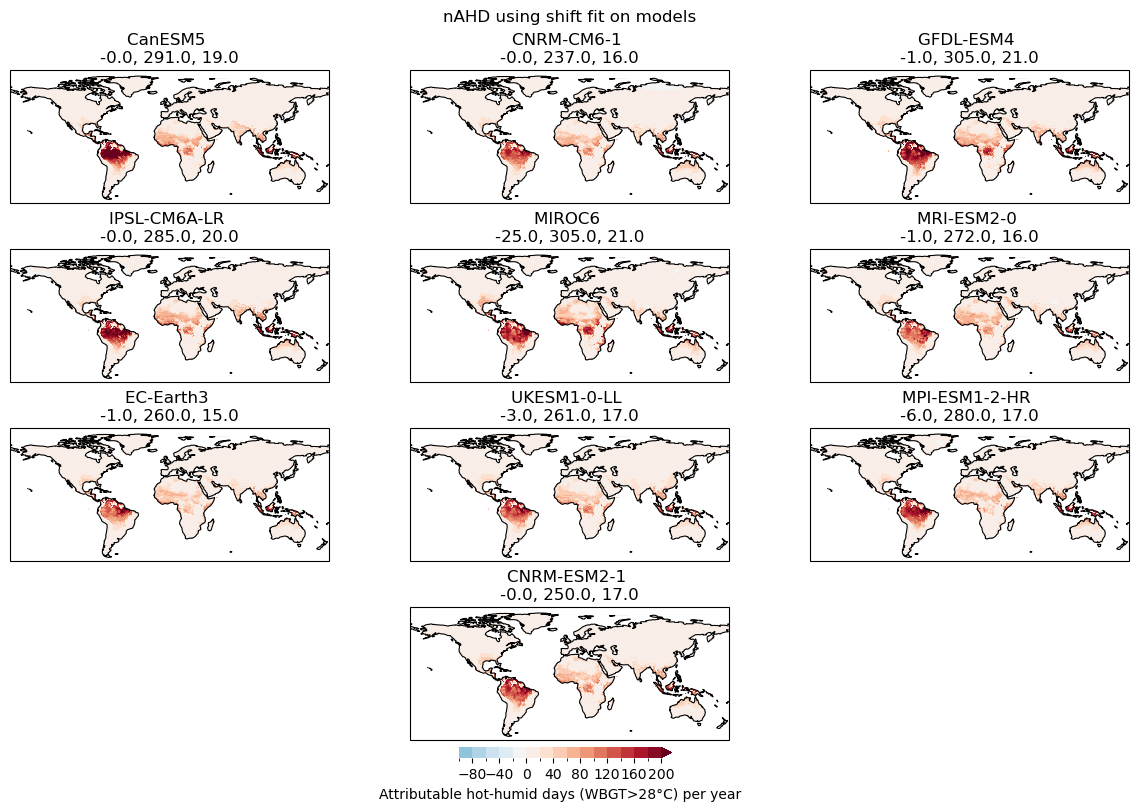

In [16]:
#import string
landmask = get_mask()

# Settings
proj = crs = ccrs.PlateCarree()
vmin, vmax, levels = -100, 200, np.linspace(-100, 200, 16) # standard in fxn 
#titles = [f"{letter}" for letter in string.ascii_lowercase[:13]]

# Create figure layout
fig = plt.figure(figsize=(12,8), layout='constrained')
gs = gridspec.GridSpec(4, 6, figure=fig)


# Plot model data
for i in range(4):
    for j in range(3):
        if i*3 + j > 8: break
        ax = fig.add_subplot(gs[i, j*2:j*2+2], projection=proj)
        data_plot = da_nAHD_mod_sf.isel(model=i*3+j) * landmask
        plot_map_nAHD(data_plot,
                  ax, 
                  #title_label=titles[3 + (i-1)*3 + j],
                     )

# Extra model subplot
ax = fig.add_subplot(gs[3, 2:4], projection=proj)
data_plot = da_nAHD_mod_sf.isel(model=9) * landmask
plot = plot_map_nAHD(data_plot,
                  ax,
                  #title_label=titles[-1],
             )

# Colorbar
cbar = fig.colorbar(plot, extend='max', ax=ax, location='bottom', shrink=1, fraction=0.08)
cbar.set_label('Attributable hot-humid days (WBGT>28°C) per year', )
cbar.outline.set_edgecolor('none')

fig.suptitle('nAHD using shift fit on models');

# 2) Compare nAHD from models using emp. pctl vs. using shift fit

## Open EP data from models 

In [17]:
dirname='output_empirical'
models='ISIMIP3b'

year=2023

da_nAHD_mod_emp = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, year_pres=year)
empty, da_p1_models_emp = open_all_p0_p1(GCMs, metric='WBGT28', outdirname=dirname, year_pres=year)

## Plot difference

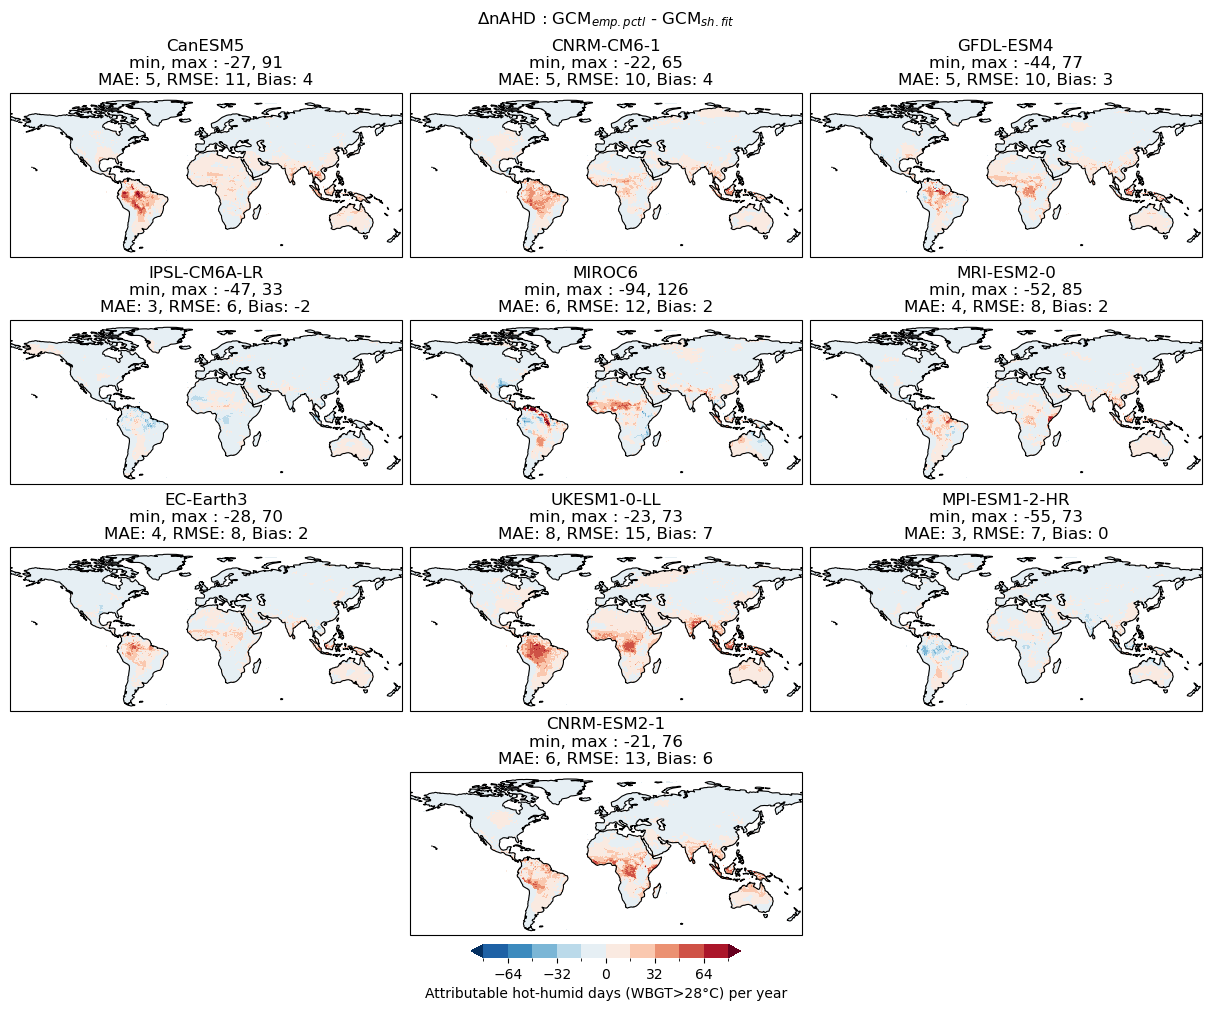

In [18]:
#import string
landmask = get_mask()

# Settings
proj = crs = ccrs.PlateCarree()
vmin, vmax = -80,80
levels = np.linspace(vmin, vmax, 11) # standard in fxn 

# Create figure layout
fig = plt.figure(figsize=(12,10), layout='constrained')
gs = gridspec.GridSpec(4, 6, figure=fig)



# Plot model data
for i in range(4):
    for j in range(3):
        if i*3 + j > 8: break
        ax = fig.add_subplot(gs[i, j*2:j*2+2], projection=proj)
        data1=da_nAHD_mod_emp.isel(model=i*3+j)
        data2=da_nAHD_mod_sf.isel(model=i*3+j)
        data_plot = ( data1 - data2 ) * landmask
        plot_map_nAHD(data_plot,
                  ax, vmin=vmin, vmax=vmax, levels=levels, skew=False
                     )
        ax.set_title(
            f"{data_plot.model.values}\n"
            f"min, max : {int(data_plot.min().values.round(0))}, {int(data_plot.max().values.round(0))}\n"
            f"MAE: {int(mae_weighted(data1, data2).values.round(0))}, "
            f"RMSE: {int(rmse_weighted(data1, data2).values.round(0))}, "
            f"Bias: {int(bias_weighted(data1, data2).values.round(0))}"
        )

# Extra model subplot
ax = fig.add_subplot(gs[3, 2:4], projection=proj)
data1=da_nAHD_mod_emp.isel(model=9)
data2=da_nAHD_mod_sf.isel(model=9)
data_plot = ( data1  - data2) * landmask
plot = plot_map_nAHD(data_plot,
                  ax, vmin=vmin, vmax=vmax, levels=levels, skew=False
             )
ax.set_title(
    f"{data_plot.model.values}\n"
    f"min, max : {int(data_plot.min().values.round(0))}, {int(data_plot.max().values.round(0))}\n"
    f"MAE: {int(mae_weighted(data1, data2).values.round(0))}, "
    f"RMSE: {int(rmse_weighted(data1, data2).values.round(0))}, "
    f"Bias: {int(bias_weighted(data1, data2).values.round(0))}"
)
# Colorbar
cbar = fig.colorbar(plot, ax=ax, location='bottom', shrink=1, fraction=0.08)
cbar.set_label('Attributable hot-humid days (WBGT>28°C) per year', )
cbar.outline.set_edgecolor('none')

fig.suptitle('$\Delta$nAHD : GCM$_{emp. pctl}$ - GCM$_{sh. fit}$');

## Notes 

Difference maps: some models show low, non-systematic bias between the two methods. In some models, EP shows a higher attributable signal, in particular in lower latitudes (SSA, N South America, Indonesia). In particular, UKESM, CNRM (2 versions) and CanESM show greatest difference between EP and SF across all continents, while EC Earth shows difference in Amazon and GFDL in Africa. 

To do : print some summary values : area weighted mean, RMSE, MAE etc.per model 

## Summary figures

In [19]:
rmse_weighted(da_nAHD_mod_emp.isel(model=9), da_nAHD_mod_sf.isel(model=9), cellarea)

<xarray.DataArray ()>
array(13.14061866)
Coordinates:
    model    <U13 'CNRM-ESM2-1'

In [20]:
mae_weighted(da_nAHD_mod_emp.isel(model=9), da_nAHD_mod_sf.isel(model=9), cellarea)

<xarray.DataArray ()>
array(6.46976584)
Coordinates:
    model    <U13 'CNRM-ESM2-1'

In [21]:
bias_weighted(da_nAHD_mod_emp.isel(model=9), da_nAHD_mod_sf.isel(model=9), cellarea)

<xarray.DataArray ()>
array(5.79808444)
Coordinates:
    model    <U13 'CNRM-ESM2-1'

# 3) plot distribution of bias and scatterplot

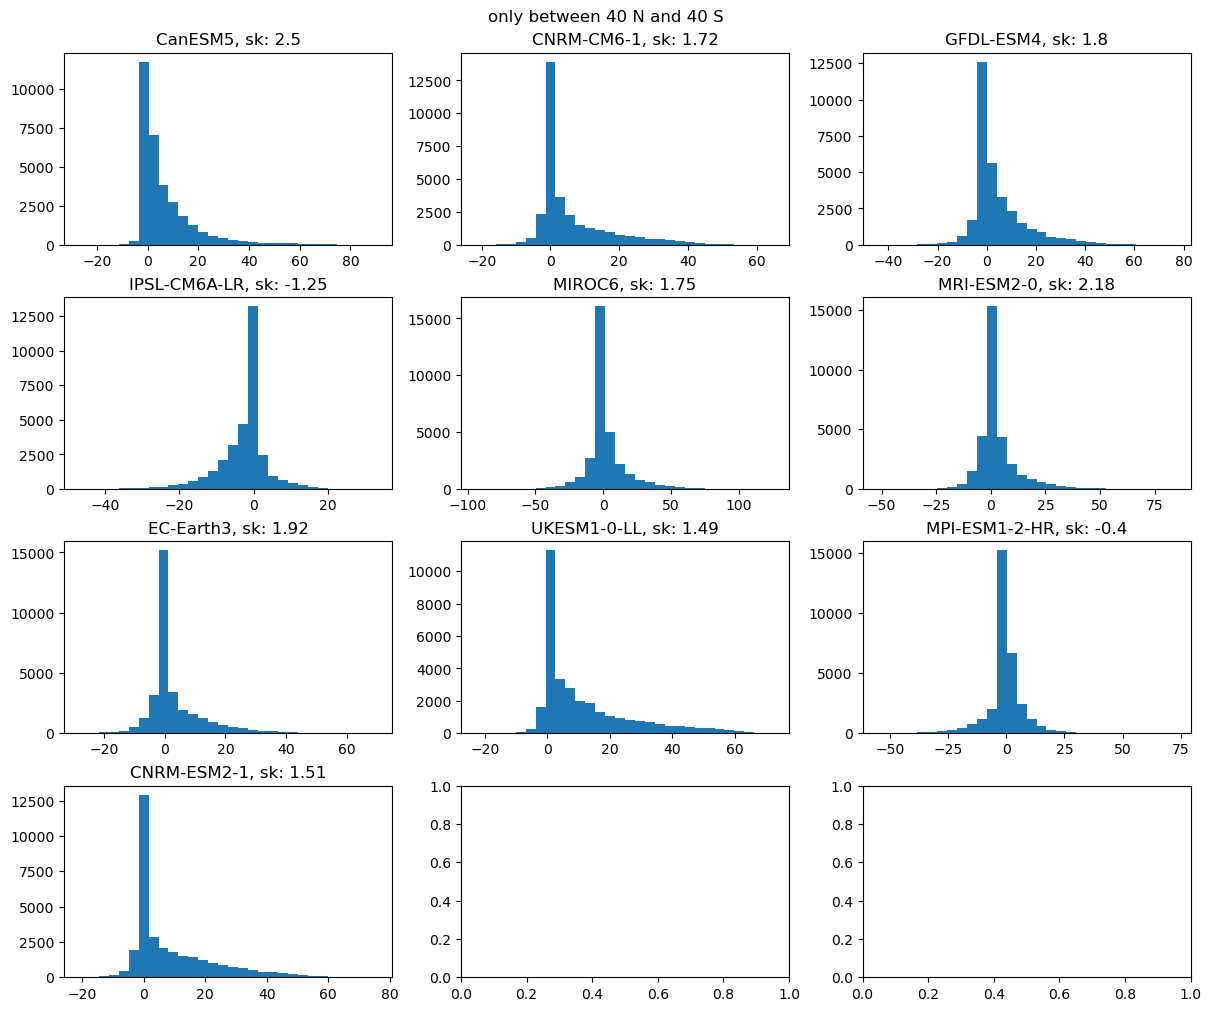

In [22]:
from scipy.stats import skew

fig, axes = plt.subplots(4,3, figsize=(12,10), layout='constrained')

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i > 9: break
    data_plot = ( da_nAHD_mod_emp.isel(model=i) - da_nAHD_mod_sf.isel(model=i) ).sel(lat=slice(40,-40)) * landmask
    data_skew = skew(data_plot.values.flatten(),nan_policy='omit')

    data_plot.plot.hist(ax=ax, bins=30)
    ax.set_title(f'{data_plot.model.values}, sk: {round(data_skew,2)}')



fig.suptitle('only between 40 N and 40 S');

#Fisher-Pearson coefficient of skewness https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html

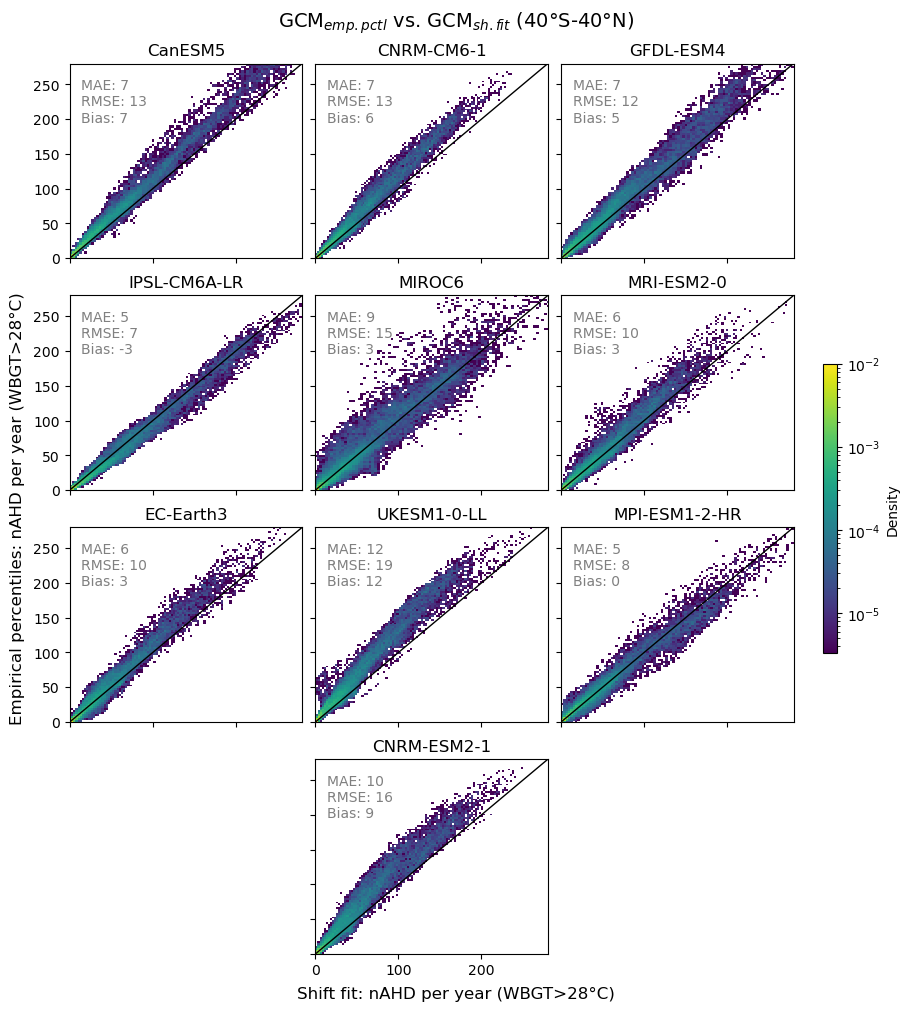

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

fig, axes = plt.subplots(4, 3, figsize=(9, 10), constrained_layout=True, sharex=True, sharey=True)
axes = axes.flatten()
vmax = .01

# Collect all histograms for shared colorbar scaling
hist_data = []

cellarea_sel = cellarea.sel(lat=slice(40, -40))

# Plot data on the first 10 axes, ignore the last two
for i, ax in enumerate( np.concatenate((axes[:len(GCMs)-1], [axes[-2]])) ):
    if i >= 10:
        break
    data1 = da_nAHD_mod_sf.isel(model=i).sel(lat=slice(40, -40)) * landmask
    data2 = da_nAHD_mod_emp.isel(model=i).sel(lat=slice(40, -40)) * landmask
    
    x = data1.values.flatten()
    y = data2.values.flatten()
    xy = np.column_stack([x, y])
    xy = xy[~np.isnan(xy).any(axis=1)]
    
    h = ax.hist2d(xy[:, 0], xy[:, 1], bins=100, density=True, norm=colors.LogNorm(vmax=vmax) )
    hist_data.append(h[3])  # Store the mappable object for colorbar scaling

    ax.axline((0, 0), slope=1, color='k', linewidth=1)
    ax.set_title(f'{da_nAHD_mod_emp.isel(model=i).model.values.item()}')
    ax.set_ylim([0,280])
    ax.set_xlim([0,280])
    ax.text(.05,.7, 
            f"MAE: {int(mae_weighted(data2, data1, cellarea_sel ).values.round(0))}\n"
            f"RMSE: {int(rmse_weighted(data2, data1, cellarea_sel).values.round(0))}\n"
            f"Bias: {int(bias_weighted(data2, data1, cellarea_sel).values.round(0))}" ,
            transform=ax.transAxes,
            c='gray')

# Add a single colorbar shared across all subplots
cbar = fig.colorbar(hist_data[0], ax=axes[:len(GCMs)], orientation="vertical", fraction=0.02, pad=0.04)
cbar.set_label('Density')

# Remove the two empty subplots
for ax in (axes[-3], axes[-1]):
    ax.remove()

fig.suptitle('GCM$_{emp. pctl}$ vs. GCM$_{sh. fit}$ (40°S-40°N)',fontsize=14)
fig.supxlabel('Shift fit: nAHD per year (WBGT>28°C)')
fig.supylabel('Empirical percentiles: nAHD per year (WBGT>28°C) ');


#plt.savefig(os.path.join(figdir,'figSI11_modeleval_sf_ep.pdf'),dpi=300,transparent=True)
#plt.savefig(os.path.join(figdir,'figSI11_modeleval_sf_ep.png'),dpi=300,transparent=True)



Comparing model results using empirical percentiles vs. using shift fit on models, agreement is not bad. In some models, bias is low and centered on zero, suggesting the two methods give similar results given the same data. In other models, the bias is right-skewed, with empirical percentiles giving larger nAHD values. This suggests the shift fit method could underestimate the attributable signal. But this is not the case across all models thus seems not to be totally systematic. 

Note: 
- could plot nAHD or the bias against the p0/p1 rarity of the day
- also plot shift fit models - shift fit reanalysis ! 


## Compare SF and EP models vs. reanalysis

### 1) open reanalysis shift fit results

In [24]:
# open data
flags['models']='ISIMIP3a'
dirname = 'output_shift-fit' 

da_list = []

for i in range(len(datasets)):
    dataset = datasets[i]
    filepath = glob.glob(os.path.join(outdirs, 
                                      f'{dirname}/{dir_shift_fit}/WBGT/ISIMIP3a/{dataset}/*_obsclim_WBGT_params_shift_loc_mon_{start_year}_2019.nc'))[0]
    da = xr.open_dataarray(filepath).expand_dims("dataset").assign_coords(dataset=("dataset", [dataset]))
    da_list.append(da)
    da_params = xr.concat(da_list, dim="dataset")

# covariate
gmst_smo = get_gmst_smo(ntime=4, observed_warming_path=observed_warming_path_annual)



In [25]:
# calc nAHD
threshold = 28
da_nAHD_obs, da_nAHD_mo, da_p0, da_p1 = calc_nAHD_shift_fit(da_params, threshold, gmst_smo,year_pres=2023,GWI=1.3)


In [26]:
# calc p1
days_in_month = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
days_in_month_da = xr.DataArray(days_in_month, dims=['month'], coords={'month': da_p1['month']})
da_p1_obs = (da_p1 * days_in_month_da).sum(dim='month')

## 2) plot EP - reanalysis sf for different reanalysis datasets

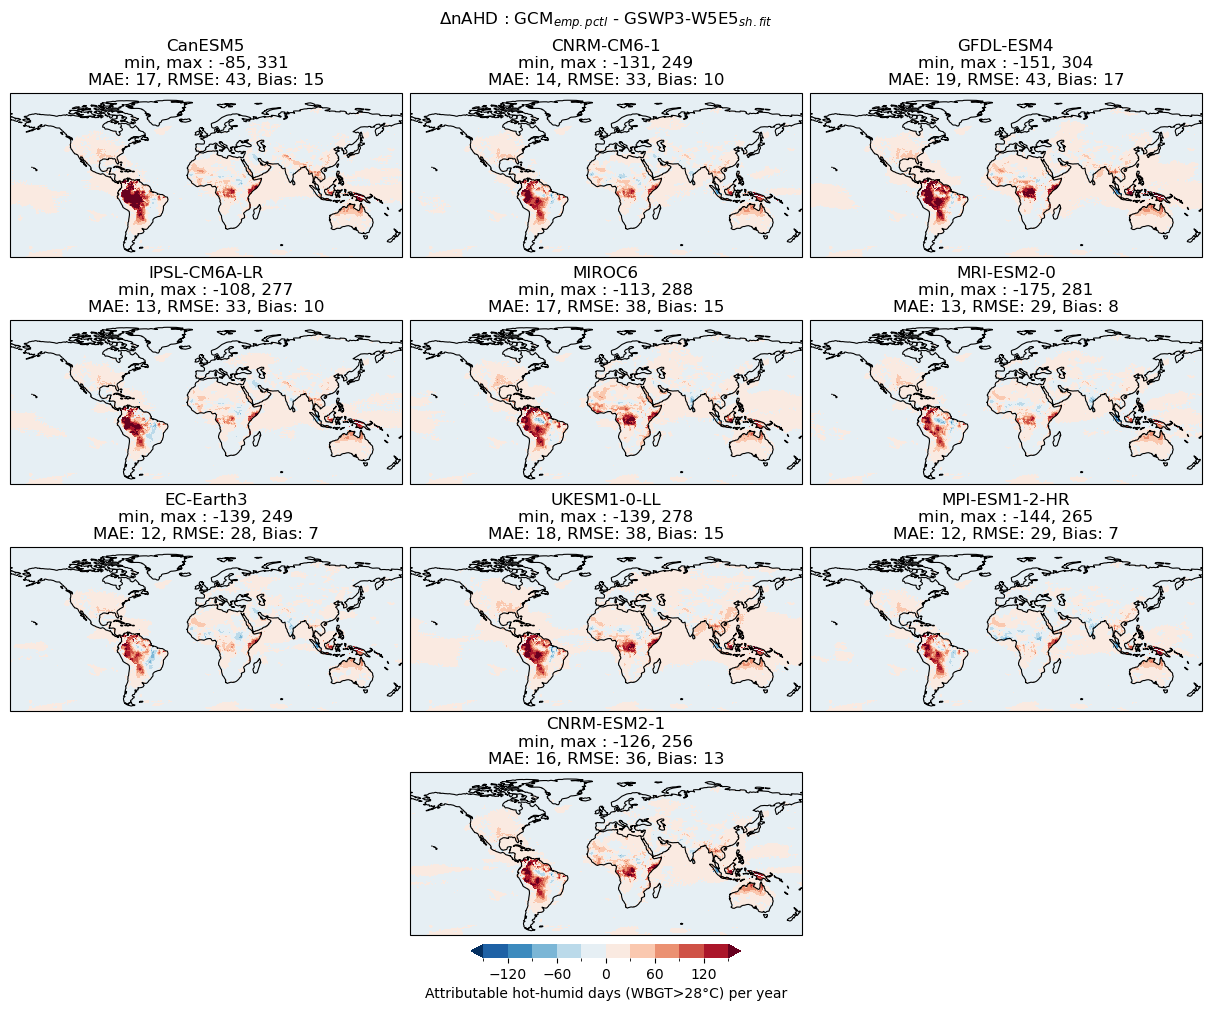

In [27]:
#import string
landmask = get_mask()

# Settings
proj = crs = ccrs.PlateCarree()
vmin, vmax = -150,150
levels = np.linspace(vmin, vmax, 11) # standard in fxn 

# Create figure layout
fig = plt.figure(figsize=(12,10), layout='constrained')
gs = gridspec.GridSpec(4, 6, figure=fig)

dataset=0


# Plot model data
for i in range(4):
    for j in range(3):
        if i*3 + j > 8: break
        ax = fig.add_subplot(gs[i, j*2:j*2+2], projection=proj)
        data1=da_nAHD_mod_emp.isel(model=i*3+j)
        data2=da_nAHD_obs.isel(dataset=dataset)
        data_plot = ( data1 - data2 ) #* landmask
        plot_map_nAHD(data_plot,
                  ax, vmin=vmin, vmax=vmax, levels=levels, skew=False
                     )
        ax.set_title(
            f"{data_plot.model.values}\n"
            f"min, max : {int(data_plot.min().values.round(0))}, {int(data_plot.max().values.round(0))}\n"
            f"MAE: {int(mae_weighted(data1, data2).values.round(0))}, "
            f"RMSE: {int(rmse_weighted(data1, data2).values.round(0))}, "
            f"Bias: {int(bias_weighted(data1, data2).values.round(0))}"
        )

# Extra model subplot
ax = fig.add_subplot(gs[3, 2:4], projection=proj)
data1=da_nAHD_mod_emp.isel(model=9)
data2=da_nAHD_obs.isel(dataset=dataset)
data_plot = ( data1  - data2) #* landmask
plot = plot_map_nAHD(data_plot,
                  ax, vmin=vmin, vmax=vmax, levels=levels, skew=False
             )
ax.set_title(
    f"{data_plot.model.values}\n"
    f"min, max : {int(data_plot.min().values.round(0))}, {int(data_plot.max().values.round(0))}\n"
    f"MAE: {int(mae_weighted(data1, data2).values.round(0))}, "
    f"RMSE: {int(rmse_weighted(data1, data2).values.round(0))}, "
    f"Bias: {int(bias_weighted(data1, data2).values.round(0))}"
)
# Colorbar
cbar = fig.colorbar(plot, ax=ax, location='bottom', shrink=1, fraction=0.08)
cbar.set_label('Attributable hot-humid days (WBGT>28°C) per year', )
cbar.outline.set_edgecolor('none')

fig.suptitle('$\Delta$nAHD : GCM$_{emp. pctl}$ - '+f'{datasets[dataset]}'+'$_{sh. fit}$');

## 3) GCM SF - Reanalysis SF

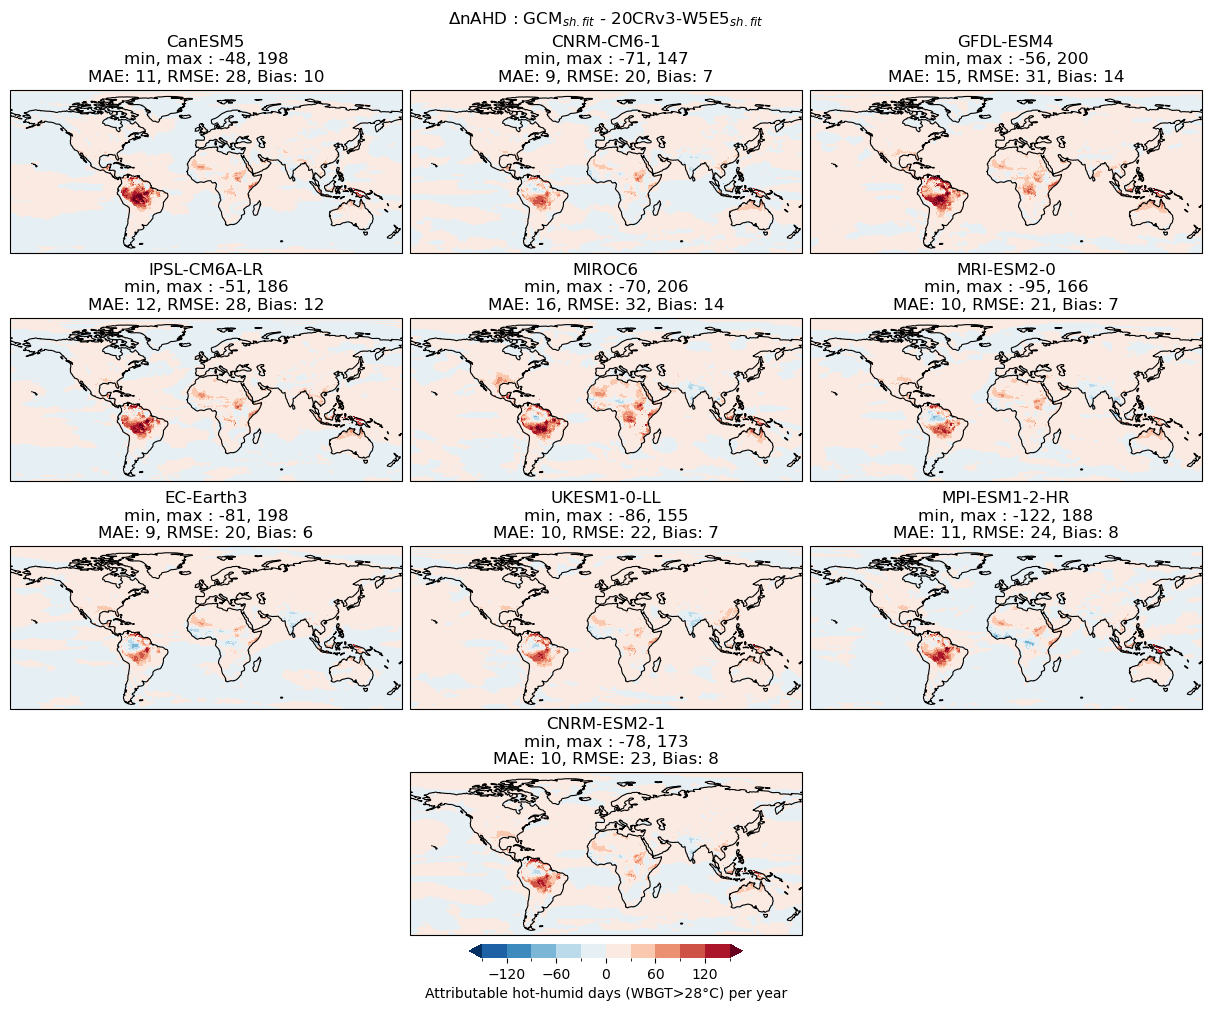

In [28]:
#import string
landmask = get_mask()

# Settings
proj = crs = ccrs.PlateCarree()
vmin, vmax = -150,150
levels = np.linspace(vmin, vmax, 11) # standard in fxn 

# Create figure layout
fig = plt.figure(figsize=(12,10), layout='constrained')
gs = gridspec.GridSpec(4, 6, figure=fig)

dataset=2


# Plot model data
for i in range(4):
    for j in range(3):
        if i*3 + j > 8: break
        ax = fig.add_subplot(gs[i, j*2:j*2+2], projection=proj)
        data1=da_nAHD_mod_sf.isel(model=i*3+j)
        data2=da_nAHD_obs.isel(dataset=dataset)
        data_plot = ( data1 - data2 ) #* landmask
        plot_map_nAHD(data_plot,
                  ax, vmin=vmin, vmax=vmax, levels=levels, skew=False
                     )
        ax.set_title(
            f"{data_plot.model.values}\n"
            f"min, max : {int(data_plot.min().values.round(0))}, {int(data_plot.max().values.round(0))}\n"
            f"MAE: {int(mae_weighted(data1, data2).values.round(0))}, "
            f"RMSE: {int(rmse_weighted(data1, data2).values.round(0))}, "
            f"Bias: {int(bias_weighted(data1, data2).values.round(0))}"
        )

# Extra model subplot
ax = fig.add_subplot(gs[3, 2:4], projection=proj)
data1=da_nAHD_mod_sf.isel(model=9)
data2=da_nAHD_obs.isel(dataset=dataset)
data_plot = ( data1  - data2) #* landmask
plot = plot_map_nAHD(data_plot,
                  ax, vmin=vmin, vmax=vmax, levels=levels, skew=False
             )
ax.set_title(
    f"{data_plot.model.values}\n"
    f"min, max : {int(data_plot.min().values.round(0))}, {int(data_plot.max().values.round(0))}\n"
    f"MAE: {int(mae_weighted(data1, data2).values.round(0))}, "
    f"RMSE: {int(rmse_weighted(data1, data2).values.round(0))}, "
    f"Bias: {int(bias_weighted(data1, data2).values.round(0))}"
)
# Colorbar
cbar = fig.colorbar(plot, ax=ax, location='bottom', shrink=1, fraction=0.08)
cbar.set_label('Attributable hot-humid days (WBGT>28°C) per year', )
cbar.outline.set_edgecolor('none')

fig.suptitle('$\Delta$nAHD : GCM$_{sh. fit}$ - '+f'{datasets[dataset]}'+'$_{sh. fit}$');

# most similar to 20CRv3-W5E5 I think! lowest RMSE and MAE 

## Diff of diff 

## 4) what % of difference is due to method

### total difference explained by method

Maps show: where differences agree in sign and not over-explained, the % explained by the method difference

i.e. [ (GCM_ep - GCM_sf) / (GCM_ep - obs) ] * 100 where this is between 0 and 100, i.e. where they agree in sign (not negative ratio, <0) and not overxplained (not >100).

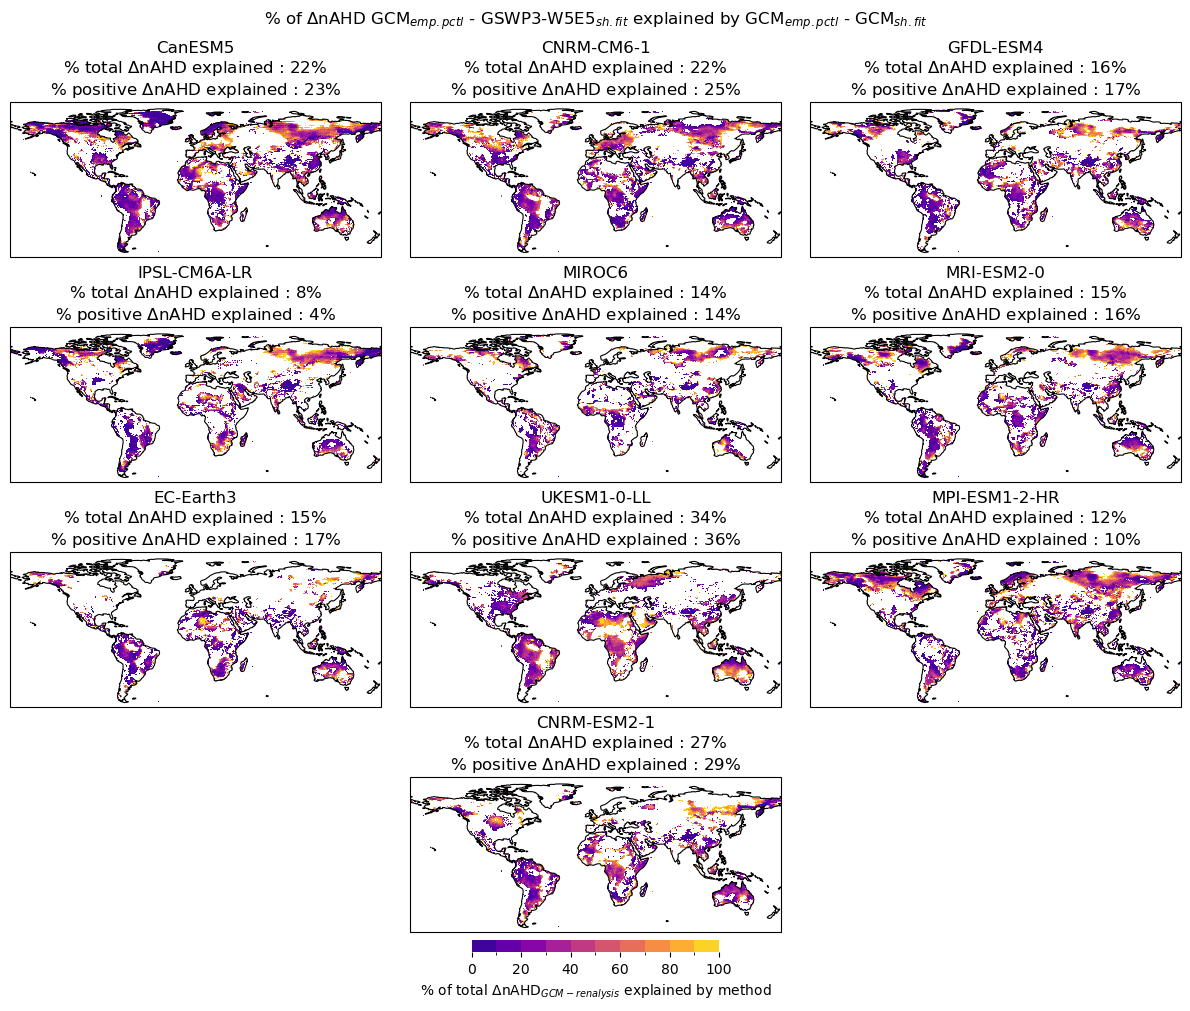

In [29]:
#import string
landmask = get_mask()

# Settings
proj = crs = ccrs.PlateCarree()
vmin, vmax = 0,100
levels = np.linspace(vmin, vmax, 11) # standard in fxn 
cmap = 'plasma'

# Create figure layout
fig = plt.figure(figsize=(12,10), layout='constrained')
gs = gridspec.GridSpec(4, 6, figure=fig)

dataset=0 # check with different datasets! 


# Plot model data
for i in range(4):
    for j in range(3):
        if i*3 + j > 8: break
        ax = fig.add_subplot(gs[i, j*2:j*2+2], projection=proj)

        # per grid cell % explained by method difference, where agree in sign (data4>0) and where doesnt overexplain (data4<100)
        data1=da_nAHD_mod_emp.isel(model=i*3+j)
        data2=da_nAHD_mod_sf.isel(model=i*3+j)
        data3=da_nAHD_obs.isel(dataset=dataset)
        data4= (( data1 - data2 ) / (data1 - data3)) * 100
        data_plot = xr.where((data4>0) & (data4 <= 100), data4, data4 * np.nan)  * landmask

        # plot 
        plot_map_nAHD(data_plot,
                  ax, vmin=vmin, vmax=vmax, levels=levels, skew=False,
                      cmap=cmap
                     )

        # a summary metric
        # pct_explained = (data1-data3).sum(lat,lon) / (data1-data2).where(data4 between 0 and 100).sum(lat,lon)
        pct_explained = ((np.abs(data1-data2)).where((data4>0) & (data4 <= 100)).sum(dim=['lat','lon']) / (np.abs(data1-data3)).sum(dim=['lat','lon']))*100

        # percent positive explained 
        pct_explained_pos = ((np.abs(data1-data2)).where((data4>0) & (data4 <= 100) & (data1-data2 >0)).sum(dim=['lat','lon']) / (np.abs(data1-data3)).where(data1-data3 >0).sum(dim=['lat','lon']))*100
        
        ax.set_title(
            f"{data_plot.model.values}\n"
            f"% total $\Delta$nAHD explained : {int(pct_explained.round(0))}%\n"
            f"% positive $\Delta$nAHD explained : {int(pct_explained_pos.round(0))}%"
        )

# Extra model subplot
ax = fig.add_subplot(gs[3, 2:4], projection=proj)

data1=da_nAHD_mod_emp.isel(model=9)
data2=da_nAHD_mod_sf.isel(model=9)
data3=da_nAHD_obs.isel(dataset=dataset)
data4= (( data1 - data2 ) / (data1 - data3)) * 100
data_plot = xr.where((data4>0) & (data4 <= 100), data4, data4 * np.nan)  * landmask

plot = plot_map_nAHD(data_plot,
                  ax, vmin=vmin, vmax=vmax, levels=levels, skew=False,
                     cmap=cmap
             )

pct_explained = ((np.abs(data1-data2)).where((data4>0) & (data4 <= 100)).sum(dim=['lat','lon']) / (np.abs(data1-data3)).sum(dim=['lat','lon']))*100

# percent positive explained 
pct_explained_pos = ((np.abs(data1-data2)).where((data4>0) & (data4 <= 100) & (data1-data2 >0)).sum(dim=['lat','lon']) / (np.abs(data1-data3)).where(data1-data3 >0).sum(dim=['lat','lon']))*100
        
ax.set_title(
    f"{data_plot.model.values}\n"
    f"% total $\Delta$nAHD explained : {int(pct_explained.round(0))}%\n"
    f"% positive $\Delta$nAHD explained : {int(pct_explained_pos.round(0))}%"
)
# Colorbar
cbar = fig.colorbar(plot, ax=ax, location='bottom', extend='neither', shrink=1, fraction=0.08)
cbar.set_label('% of total $\Delta$nAHD$_{GCM - renalysis}$ explained by method', )
cbar.outline.set_edgecolor('none')

fig.suptitle('% of $\Delta$nAHD GCM$_{emp. pctl}$ - '+f'{datasets[dataset]}'+'$_{sh. fit}$ explained by GCM$_{emp. pctl}$ - GCM$_{sh. fit}$');

### positive difference explained

Maps show positive difference, i.e.

[ (GCM_ep - GCM_sf) / (GCM_ep - obs) ] * 100 where this is between 0 and 100, i.e. where they agree in sign (not negative ratio, <0) and not overxplained (not >100), and both numerator and denominator are positive

% explained = [ spatial_sum(GCM_ep - GCM_sf) / spatial_sum(GCM_ep - obs) ] only summing pixels where the differences are positive. in numerator only summing pixels where difference is not over-explained. 

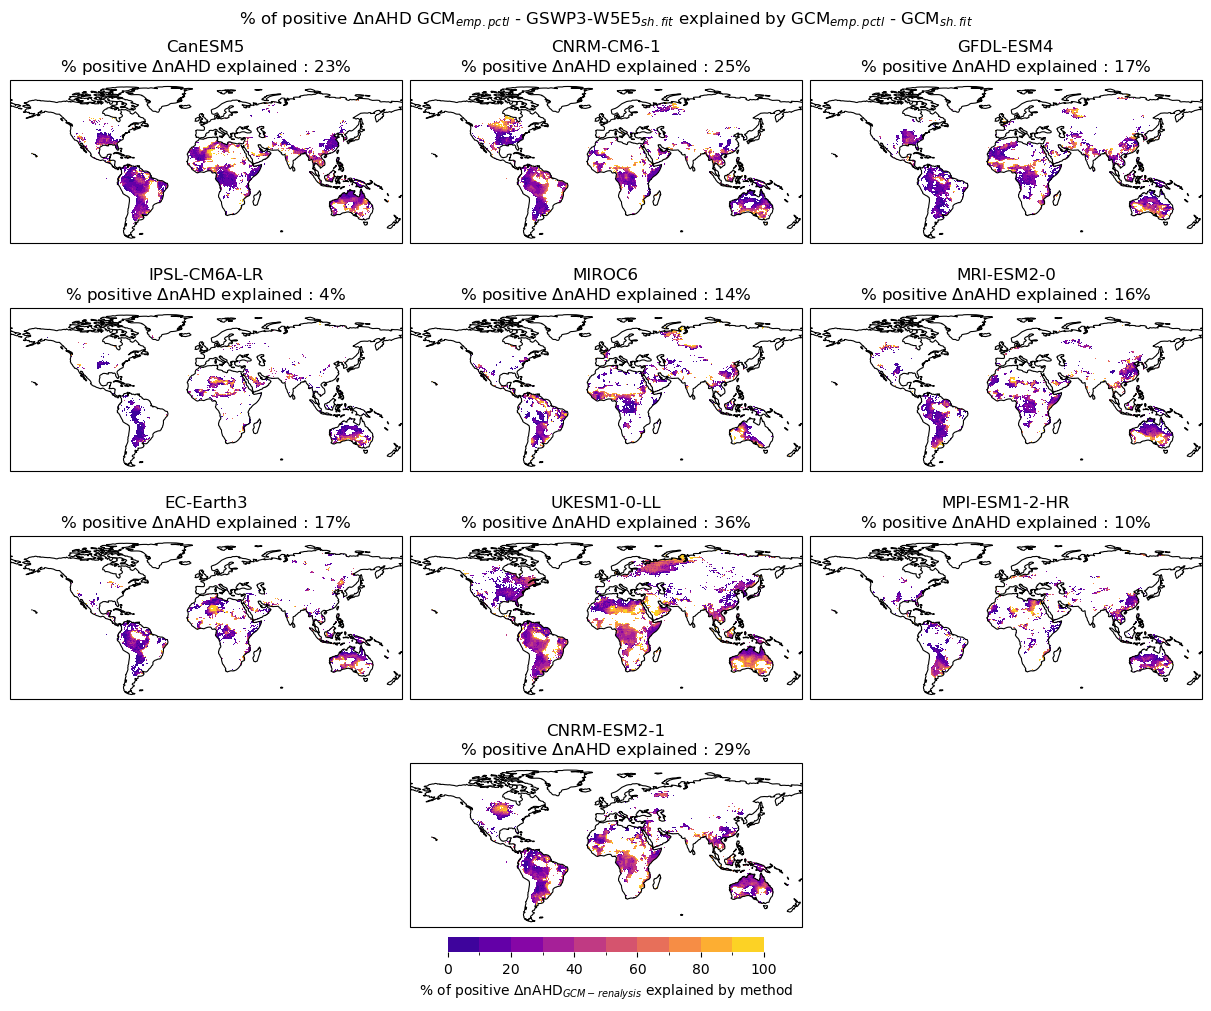

In [30]:
#import string
landmask = get_mask()

# Settings
proj = crs = ccrs.PlateCarree()
vmin, vmax = 0,100
levels = np.linspace(vmin, vmax, 11) # standard in fxn 
cmap = 'plasma'

# Create figure layout
fig = plt.figure(figsize=(12,10), layout='constrained')
gs = gridspec.GridSpec(4, 6, figure=fig)

dataset=0 # check with different datasets! 


# Plot model data
for i in range(4):
    for j in range(3):
        if i*3 + j > 8: break
        ax = fig.add_subplot(gs[i, j*2:j*2+2], projection=proj)

        # per grid cell % explained by method difference, where agree in sign (data4>0) and where doesnt overexplain (data4<100)
        data1=da_nAHD_mod_emp.isel(model=i*3+j)
        data2=da_nAHD_mod_sf.isel(model=i*3+j)
        data3=da_nAHD_obs.isel(dataset=dataset)
        data4= (( data1 - data2 ) / (data1 - data3)) * 100
        data_plot = xr.where((data4>0) & (data4 <= 100) & ( data1 - data2 >0 ), data4, data4 * np.nan)  * landmask

        # plot 
        plot_map_nAHD(data_plot,
                  ax, vmin=vmin, vmax=vmax, levels=levels, skew=False,
                      cmap=cmap
                     )

        # a summary metric
        # pct_explained = (data1-data3).sum(lat,lon) / (data1-data2).where(data4 between 0 and 100).sum(lat,lon)
        #pct_explained = ((np.abs(data1-data2)).where((data4>0) & (data4 <= 100)).sum(dim=['lat','lon']) / (np.abs(data1-data3)).sum(dim=['lat','lon']))*100

        # percent positive explained 
        pct_explained_pos = ((np.abs(data1-data2)).where((data4>0) & (data4 <= 100) & (data1-data2 >0)).sum(dim=['lat','lon']) / (np.abs(data1-data3)).where(data1-data3 >0).sum(dim=['lat','lon']))*100
        
        ax.set_title(
            f"{data_plot.model.values}\n"
            #f"% total $\Delta$nAHD explained : {int(pct_explained.round(0))}%\n"
            f"% positive $\Delta$nAHD explained : {int(pct_explained_pos.round(0))}%"
        )

# Extra model subplot
ax = fig.add_subplot(gs[3, 2:4], projection=proj)

data1=da_nAHD_mod_emp.isel(model=9)
data2=da_nAHD_mod_sf.isel(model=9)
data3=da_nAHD_obs.isel(dataset=dataset)
data4= (( data1 - data2 ) / (data1 - data3)) * 100
data_plot = xr.where((data4>0) & (data4 <= 100) & ( data1 - data2 >0 ) , data4, data4 * np.nan)  * landmask

plot = plot_map_nAHD(data_plot,
                  ax, vmin=vmin, vmax=vmax, levels=levels, skew=False,
                     cmap=cmap
             )

#pct_explained = ((np.abs(data1-data2)).where((data4>0) & (data4 <= 100)).sum(dim=['lat','lon']) / (np.abs(data1-data3)).sum(dim=['lat','lon']))*100

# percent positive explained 
pct_explained_pos = ((np.abs(data1-data2)).where((data4>0) & (data4 <= 100) & (data1-data2 >0)).sum(dim=['lat','lon']) / (np.abs(data1-data3)).where(data1-data3 >0).sum(dim=['lat','lon']))*100
        
ax.set_title(
    f"{data_plot.model.values}\n"
    #f"% total $\Delta$nAHD explained : {int(pct_explained.round(0))}%\n"
    f"% positive $\Delta$nAHD explained : {int(pct_explained_pos.round(0))}%"
)
# Colorbar
cbar = fig.colorbar(plot, ax=ax, location='bottom', extend='neither', shrink=1, fraction=0.08)
cbar.set_label('% of positive $\Delta$nAHD$_{GCM - renalysis}$ explained by method', )
cbar.outline.set_edgecolor('none')

fig.suptitle('% of positive $\Delta$nAHD GCM$_{emp. pctl}$ - '+f'{datasets[dataset]}'+'$_{sh. fit}$ explained by GCM$_{emp. pctl}$ - GCM$_{sh. fit}$');

#### without excluding over-explained

0.0037850949529242756 100.0


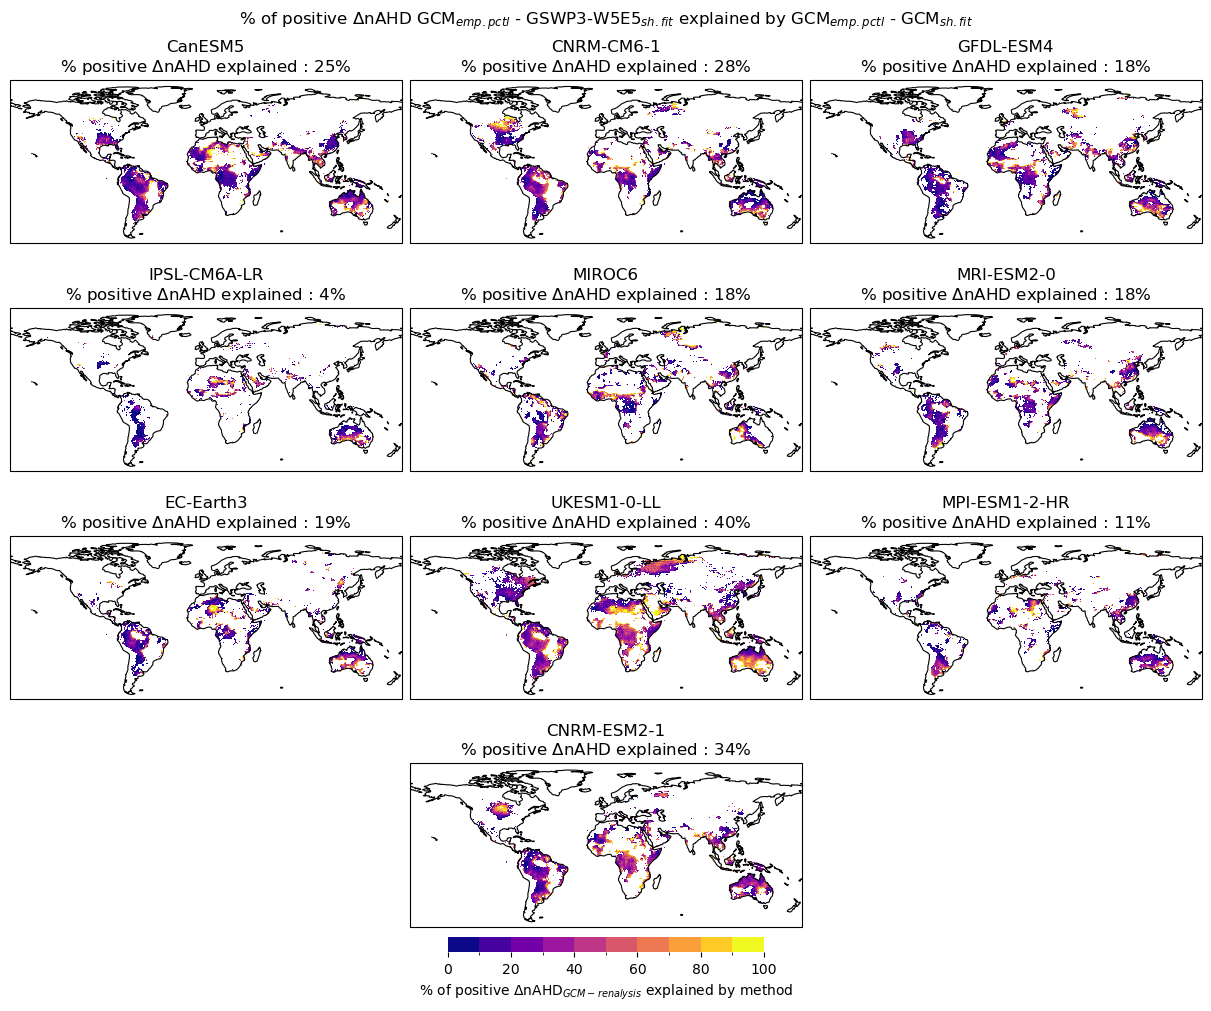

In [31]:
#import string
landmask = get_mask()

# Settings
proj = crs = ccrs.PlateCarree()
vmin, vmax = 0,100
levels = 11  
cmap = 'plasma'

# Create figure layout
fig = plt.figure(figsize=(12,10), layout='constrained')
gs = gridspec.GridSpec(4, 6, figure=fig)

dataset=0 # check with different datasets! 


# Plot model data
for i in range(4):
    for j in range(3):
        if i*3 + j > 8: break
        ax = fig.add_subplot(gs[i, j*2:j*2+2], projection=proj)

        # per grid cell % explained by method difference, where agree in sign (data4>0) and where doesnt overexplain (data4<100)
        data1=da_nAHD_mod_emp.isel(model=i*3+j)
        data2=da_nAHD_mod_sf.isel(model=i*3+j)
        data3=da_nAHD_obs.isel(dataset=dataset)
        data4= (( data1 - data2 ) / (data1 - data3)) * 100
        data_plot = xr.where((data4>0)  & ( data1 - data2 >0 ), data4, data4 * np.nan)  * landmask

        data_plot = xr.where( data_plot >100, 100, data_plot)

        # plot 
        plot_map_nAHD(data_plot,
                  ax, vmin=vmin, vmax=vmax, levels=levels, skew=False,
                      cmap=cmap,
                      extend='neither'
                     )

        # a summary metric
        # pct_explained = (data1-data3).sum(lat,lon) / (data1-data2).where(data4 between 0 and 100).sum(lat,lon)
        #pct_explained = ((np.abs(data1-data2)).where((data4>0) & (data4 <= 100)).sum(dim=['lat','lon']) / (np.abs(data1-data3)).sum(dim=['lat','lon']))*100

        # percent positive explained 
        pct_expl_less100 = (np.abs(data1-data2)).where((data4>0) & (data4<=100) & (data1-data2 >0)).sum(dim=['lat','lon']) 
        pct_expl_gr100 = xr.where((data4>0) & (data4>100) & (data1-data2 >0), np.abs(data1-data3), 0).sum(dim=['lat','lon']) 
        pct_explained_pos = ( (pct_expl_less100 + pct_expl_gr100 ) / (np.abs(data1-data3)).where(data1-data3 >0).sum(dim=['lat','lon']))*100
        
        ax.set_title(
            f"{data_plot.model.values}\n"
            #f"% total $\Delta$nAHD explained : {int(pct_explained.round(0))}%\n"
            f"% positive $\Delta$nAHD explained : {int(pct_explained_pos.round(0))}%"
        )

# Extra model subplot
ax = fig.add_subplot(gs[3, 2:4], projection=proj)

data1=da_nAHD_mod_emp.isel(model=9)
data2=da_nAHD_mod_sf.isel(model=9)
data3=da_nAHD_obs.isel(dataset=dataset)
data4= (( data1 - data2 ) / (data1 - data3)) * 100

data_plot = xr.where((data4>0)  & ( data1 - data2 >0 ) , data4, data4 * np.nan)  * landmask
data_plot = xr.where( data_plot >100, 100, data_plot)

print(data_plot.min().values, data_plot.max().values )
      
im = plot_map_nAHD(data_plot,
                  ax, vmin=vmin, vmax=vmax, levels=levels, skew=False,
                     cmap=cmap,
                   extend='neither'
             )

#pct_explained = ((np.abs(data1-data2)).where((data4>0) & (data4 <= 100)).sum(dim=['lat','lon']) / (np.abs(data1-data3)).sum(dim=['lat','lon']))*100

# percent positive explained 
#pct_explained_pos = ((np.abs(data1-data2)).where((data4>0)  & (data1-data2 >0)).sum(dim=['lat','lon']) / (np.abs(data1-data3)).where(data1-data3 >0).sum(dim=['lat','lon']))*100

pct_expl_less100 = (np.abs(data1-data2)).where((data4>0) & (data4<=100) & (data1-data2 >0)).sum(dim=['lat','lon']) 
pct_expl_gr100 = xr.where((data4>0) & (data4>100) & (data1-data2 >0), np.abs(data1-data3), 0).sum(dim=['lat','lon']) 
pct_explained_pos = ( (pct_expl_less100 + pct_expl_gr100 ) / (np.abs(data1-data3)).where(data1-data3 >0).sum(dim=['lat','lon']))*100


ax.set_title(
    f"{data_plot.model.values}\n"
    #f"% total $\Delta$nAHD explained : {int(pct_explained.round(0))}%\n"
    f"% positive $\Delta$nAHD explained : {int(pct_explained_pos.round(0))}%"
)
# Colorbar
cbar = fig.colorbar(im, ax=ax, location='bottom', extend='neither', shrink=1, fraction=0.08)
cbar.set_label('% of positive $\Delta$nAHD$_{GCM - renalysis}$ explained by method', )
cbar.outline.set_edgecolor('none')

fig.suptitle('% of positive $\Delta$nAHD GCM$_{emp. pctl}$ - '+f'{datasets[dataset]}'+'$_{sh. fit}$ explained by GCM$_{emp. pctl}$ - GCM$_{sh. fit}$');

0.004429028020337841 100.0


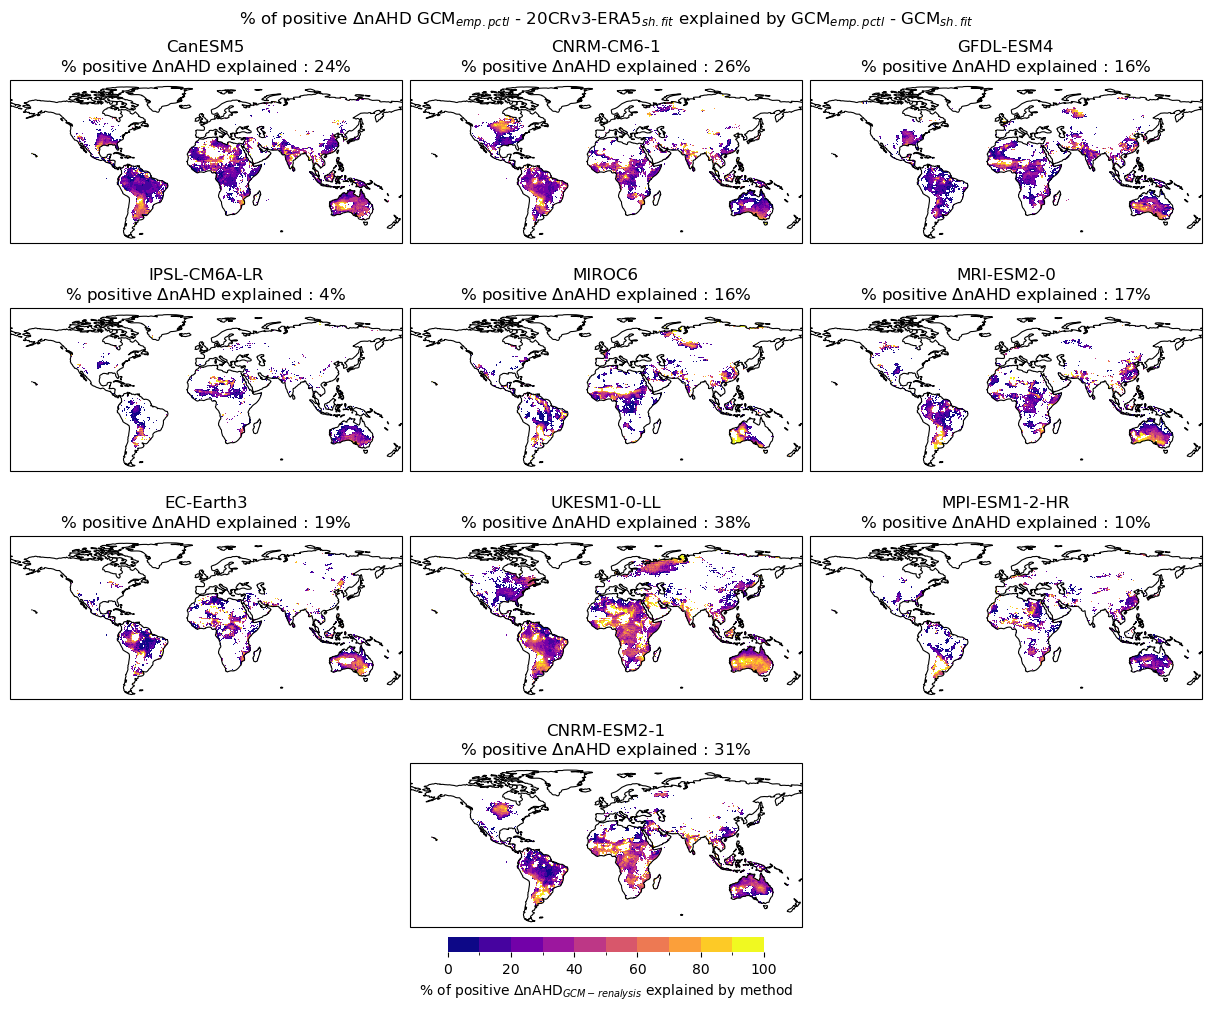

In [33]:
#import string
landmask = get_mask()

# Settings
proj = crs = ccrs.PlateCarree()
vmin, vmax = 0,100
levels = 11  
cmap = 'plasma'

# Create figure layout
fig = plt.figure(figsize=(12,10), layout='constrained')
gs = gridspec.GridSpec(4, 6, figure=fig)

dataset=1 # check with different datasets! 


# Plot model data
for i in range(4):
    for j in range(3):
        if i*3 + j > 8: break
        ax = fig.add_subplot(gs[i, j*2:j*2+2], projection=proj)

        # per grid cell % explained by method difference, where agree in sign (data4>0) and where doesnt overexplain (data4<100)
        data1=da_nAHD_mod_emp.isel(model=i*3+j)
        data2=da_nAHD_mod_sf.isel(model=i*3+j)
        data3=da_nAHD_obs.isel(dataset=dataset)
        data4= (( data1 - data2 ) / (data1 - data3)) * 100
        data_plot = xr.where((data4>0)  & ( data1 - data2 >0 ), data4, data4 * np.nan)  * landmask

        data_plot = xr.where( data_plot >100, 100, data_plot)

        # plot 
        plot_map_nAHD(data_plot,
                  ax, vmin=vmin, vmax=vmax, levels=levels, skew=False,
                      cmap=cmap,
                      extend='neither'
                     )

        # a summary metric
        # pct_explained = (data1-data3).sum(lat,lon) / (data1-data2).where(data4 between 0 and 100).sum(lat,lon)
        #pct_explained = ((np.abs(data1-data2)).where((data4>0) & (data4 <= 100)).sum(dim=['lat','lon']) / (np.abs(data1-data3)).sum(dim=['lat','lon']))*100

        # percent positive explained 
        pct_expl_less100 = (np.abs(data1-data2)).where((data4>0) & (data4<=100) & (data1-data2 >0)).sum(dim=['lat','lon']) 
        pct_expl_gr100 = xr.where((data4>0) & (data4>100) & (data1-data2 >0), np.abs(data1-data3), 0).sum(dim=['lat','lon']) 
        pct_explained_pos = ( (pct_expl_less100 + pct_expl_gr100 ) / (np.abs(data1-data3)).where(data1-data3 >0).sum(dim=['lat','lon']))*100
        
        ax.set_title(
            f"{data_plot.model.values}\n"
            #f"% total $\Delta$nAHD explained : {int(pct_explained.round(0))}%\n"
            f"% positive $\Delta$nAHD explained : {int(pct_explained_pos.round(0))}%"
        )

# Extra model subplot
ax = fig.add_subplot(gs[3, 2:4], projection=proj)

data1=da_nAHD_mod_emp.isel(model=9)
data2=da_nAHD_mod_sf.isel(model=9)
data3=da_nAHD_obs.isel(dataset=dataset)
data4= (( data1 - data2 ) / (data1 - data3)) * 100

data_plot = xr.where((data4>0)  & ( data1 - data2 >0 ) , data4, data4 * np.nan)  * landmask
data_plot = xr.where( data_plot >100, 100, data_plot)

print(data_plot.min().values, data_plot.max().values )
      
im = plot_map_nAHD(data_plot,
                  ax, vmin=vmin, vmax=vmax, levels=levels, skew=False,
                     cmap=cmap,
                   extend='neither'
             )

#pct_explained = ((np.abs(data1-data2)).where((data4>0) & (data4 <= 100)).sum(dim=['lat','lon']) / (np.abs(data1-data3)).sum(dim=['lat','lon']))*100

# percent positive explained 
#pct_explained_pos = ((np.abs(data1-data2)).where((data4>0)  & (data1-data2 >0)).sum(dim=['lat','lon']) / (np.abs(data1-data3)).where(data1-data3 >0).sum(dim=['lat','lon']))*100

pct_expl_less100 = (np.abs(data1-data2)).where((data4>0) & (data4<=100) & (data1-data2 >0)).sum(dim=['lat','lon']) 
pct_expl_gr100 = xr.where((data4>0) & (data4>100) & (data1-data2 >0), np.abs(data1-data3), 0).sum(dim=['lat','lon']) 
pct_explained_pos = ( (pct_expl_less100 + pct_expl_gr100 ) / (np.abs(data1-data3)).where(data1-data3 >0).sum(dim=['lat','lon']))*100


ax.set_title(
    f"{data_plot.model.values}\n"
    #f"% total $\Delta$nAHD explained : {int(pct_explained.round(0))}%\n"
    f"% positive $\Delta$nAHD explained : {int(pct_explained_pos.round(0))}%"
)
# Colorbar
cbar = fig.colorbar(im, ax=ax, location='bottom', extend='neither', shrink=1, fraction=0.08)
cbar.set_label('% of positive $\Delta$nAHD$_{GCM - renalysis}$ explained by method', )
cbar.outline.set_edgecolor('none')

fig.suptitle('% of positive $\Delta$nAHD GCM$_{emp. pctl}$ - '+f'{datasets[dataset]}'+'$_{sh. fit}$ explained by GCM$_{emp. pctl}$ - GCM$_{sh. fit}$');

0.005380431983586229 100.0


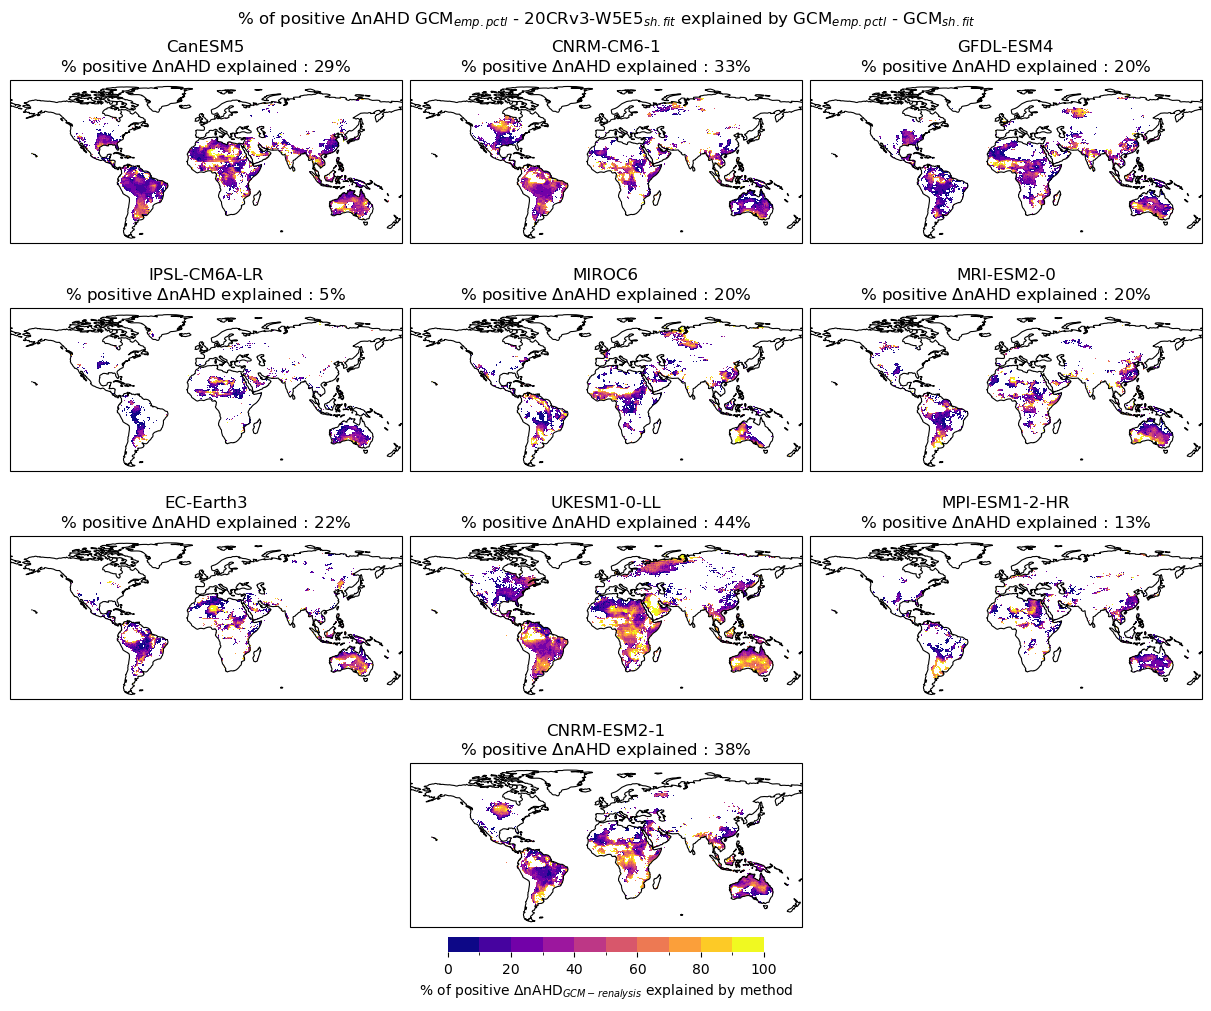

In [35]:
#import string
landmask = get_mask()

# Settings
proj = crs = ccrs.PlateCarree()
vmin, vmax = 0,100
levels = 11  
cmap = 'plasma'

# Create figure layout
fig = plt.figure(figsize=(12,10), layout='constrained')
gs = gridspec.GridSpec(4, 6, figure=fig)

dataset=2 # check with different datasets! 


# Plot model data
for i in range(4):
    for j in range(3):
        if i*3 + j > 8: break
        ax = fig.add_subplot(gs[i, j*2:j*2+2], projection=proj)

        # per grid cell % explained by method difference, where agree in sign (data4>0) and where doesnt overexplain (data4<100)
        data1=da_nAHD_mod_emp.isel(model=i*3+j)
        data2=da_nAHD_mod_sf.isel(model=i*3+j)
        data3=da_nAHD_obs.isel(dataset=dataset)
        data4= (( data1 - data2 ) / (data1 - data3)) * 100
        data_plot = xr.where((data4>0)  & ( data1 - data2 >0 ), data4, data4 * np.nan)  * landmask

        data_plot = xr.where( data_plot >100, 100, data_plot)

        # plot 
        plot_map_nAHD(data_plot,
                  ax, vmin=vmin, vmax=vmax, levels=levels, skew=False,
                      cmap=cmap,
                      extend='neither'
                     )

        # a summary metric
        # pct_explained = (data1-data3).sum(lat,lon) / (data1-data2).where(data4 between 0 and 100).sum(lat,lon)
        #pct_explained = ((np.abs(data1-data2)).where((data4>0) & (data4 <= 100)).sum(dim=['lat','lon']) / (np.abs(data1-data3)).sum(dim=['lat','lon']))*100

        # percent positive explained 
        pct_expl_less100 = (np.abs(data1-data2)).where((data4>0) & (data4<=100) & (data1-data2 >0)).sum(dim=['lat','lon']) 
        pct_expl_gr100 = xr.where((data4>0) & (data4>100) & (data1-data2 >0), np.abs(data1-data3), 0).sum(dim=['lat','lon']) 
        pct_explained_pos = ( (pct_expl_less100 + pct_expl_gr100 ) / (np.abs(data1-data3)).where(data1-data3 >0).sum(dim=['lat','lon']))*100
        
        ax.set_title(
            f"{data_plot.model.values}\n"
            #f"% total $\Delta$nAHD explained : {int(pct_explained.round(0))}%\n"
            f"% positive $\Delta$nAHD explained : {int(pct_explained_pos.round(0))}%"
        )

# Extra model subplot
ax = fig.add_subplot(gs[3, 2:4], projection=proj)

data1=da_nAHD_mod_emp.isel(model=9)
data2=da_nAHD_mod_sf.isel(model=9)
data3=da_nAHD_obs.isel(dataset=dataset)
data4= (( data1 - data2 ) / (data1 - data3)) * 100

data_plot = xr.where((data4>0)  & ( data1 - data2 >0 ) , data4, data4 * np.nan)  * landmask
data_plot = xr.where( data_plot >100, 100, data_plot)

print(data_plot.min().values, data_plot.max().values )
      
im = plot_map_nAHD(data_plot,
                  ax, vmin=vmin, vmax=vmax, levels=levels, skew=False,
                     cmap=cmap,
                   extend='neither'
             )

#pct_explained = ((np.abs(data1-data2)).where((data4>0) & (data4 <= 100)).sum(dim=['lat','lon']) / (np.abs(data1-data3)).sum(dim=['lat','lon']))*100

# percent positive explained 
#pct_explained_pos = ((np.abs(data1-data2)).where((data4>0)  & (data1-data2 >0)).sum(dim=['lat','lon']) / (np.abs(data1-data3)).where(data1-data3 >0).sum(dim=['lat','lon']))*100

pct_expl_less100 = (np.abs(data1-data2)).where((data4>0) & (data4<=100) & (data1-data2 >0)).sum(dim=['lat','lon']) 
pct_expl_gr100 = xr.where((data4>0) & (data4>100) & (data1-data2 >0), np.abs(data1-data3), 0).sum(dim=['lat','lon']) 
pct_explained_pos = ( (pct_expl_less100 + pct_expl_gr100 ) / (np.abs(data1-data3)).where(data1-data3 >0).sum(dim=['lat','lon']))*100


ax.set_title(
    f"{data_plot.model.values}\n"
    #f"% total $\Delta$nAHD explained : {int(pct_explained.round(0))}%\n"
    f"% positive $\Delta$nAHD explained : {int(pct_explained_pos.round(0))}%"
)
# Colorbar
cbar = fig.colorbar(im, ax=ax, location='bottom', extend='neither', shrink=1, fraction=0.08)
cbar.set_label('% of positive $\Delta$nAHD$_{GCM - renalysis}$ explained by method', )
cbar.outline.set_edgecolor('none')

fig.suptitle('% of positive $\Delta$nAHD GCM$_{emp. pctl}$ - '+f'{datasets[dataset]}'+'$_{sh. fit}$ explained by GCM$_{emp. pctl}$ - GCM$_{sh. fit}$');

#### excluding overexplained

what about including neg differences?

In [ ]:
#import string
landmask = get_mask()

# Settings
proj = crs = ccrs.PlateCarree()
vmin, vmax = 0,100
levels = np.linspace(vmin, vmax, 11) # standard in fxn 
cmap = 'plasma'

# Create figure layout
fig = plt.figure(figsize=(12,10), layout='constrained')
gs = gridspec.GridSpec(4, 6, figure=fig)

dataset=1 # check with different datasets! 


# Plot model data
for i in range(4):
    for j in range(3):
        if i*3 + j > 8: break
        ax = fig.add_subplot(gs[i, j*2:j*2+2], projection=proj)

        # per grid cell % explained by method difference, where agree in sign (data4>0) and where doesnt overexplain (data4<100)
        data1=da_nAHD_mod_emp.isel(model=i*3+j)
        data2=da_nAHD_mod_sf.isel(model=i*3+j)
        data3=da_nAHD_obs.isel(dataset=dataset)
        data4= (( data1 - data2 ) / (data1 - data3)) * 100
        data_plot = xr.where((data4>0) & (data4 <= 100) & ( data1 - data2 >0 ), data4, data4 * np.nan)  * landmask

        # plot 
        plot_map_nAHD(data_plot,
                  ax, vmin=vmin, vmax=vmax, levels=levels, skew=False,
                      cmap=cmap
                     )

        # a summary metric
        # pct_explained = (data1-data3).sum(lat,lon) / (data1-data2).where(data4 between 0 and 100).sum(lat,lon)
        #pct_explained = ((np.abs(data1-data2)).where((data4>0) & (data4 <= 100)).sum(dim=['lat','lon']) / (np.abs(data1-data3)).sum(dim=['lat','lon']))*100

        # percent positive explained 
        pct_explained_pos = ((np.abs(data1-data2)).where((data4>0) & (data4 <= 100) & (data1-data2 >0)).sum(dim=['lat','lon']) / (np.abs(data1-data3)).where(data1-data3 >0).sum(dim=['lat','lon']))*100
        
        ax.set_title(
            f"{data_plot.model.values}\n"
            #f"% total $\Delta$nAHD explained : {int(pct_explained.round(0))}%\n"
            f"% positive $\Delta$nAHD explained : {int(pct_explained_pos.round(0))}%"
        )

# Extra model subplot
ax = fig.add_subplot(gs[3, 2:4], projection=proj)

data1=da_nAHD_mod_emp.isel(model=9)
data2=da_nAHD_mod_sf.isel(model=9)
data3=da_nAHD_obs.isel(dataset=dataset)
data4= (( data1 - data2 ) / (data1 - data3)) * 100
data_plot = xr.where((data4>0) & (data4 <= 100) & ( data1 - data2 >0 ) , data4, data4 * np.nan)  * landmask

plot = plot_map_nAHD(data_plot,
                  ax, vmin=vmin, vmax=vmax, levels=levels, skew=False,
                     cmap=cmap
             )

#pct_explained = ((np.abs(data1-data2)).where((data4>0) & (data4 <= 100)).sum(dim=['lat','lon']) / (np.abs(data1-data3)).sum(dim=['lat','lon']))*100

# percent positive explained 
pct_explained_pos = ((np.abs(data1-data2)).where((data4>0) & (data4 <= 100) & (data1-data2 >0)).sum(dim=['lat','lon']) / (np.abs(data1-data3)).where(data1-data3 >0).sum(dim=['lat','lon']))*100
        
ax.set_title(
    f"{data_plot.model.values}\n"
    #f"% total $\Delta$nAHD explained : {int(pct_explained.round(0))}%\n"
    f"% positive $\Delta$nAHD explained : {int(pct_explained_pos.round(0))}%"
)
# Colorbar
cbar = fig.colorbar(plot, ax=ax, location='bottom', extend='neither', shrink=1, fraction=0.08)
cbar.set_label('% of positive $\Delta$nAHD$_{GCM - renalysis}$ explained by method', )
cbar.outline.set_edgecolor('none')

fig.suptitle('% of positive $\Delta$nAHD GCM$_{emp. pctl}$ - '+f'{datasets[dataset]}'+'$_{sh. fit}$ explained by GCM$_{emp. pctl}$ - GCM$_{sh. fit}$');

In [ ]:
#import string
landmask = get_mask()

# Settings
proj = crs = ccrs.PlateCarree()
vmin, vmax = 0,100
levels = np.linspace(vmin, vmax, 11) # standard in fxn 
cmap = 'plasma'

# Create figure layout
fig = plt.figure(figsize=(12,10), layout='constrained')
gs = gridspec.GridSpec(4, 6, figure=fig)

dataset=2 # check with different datasets! 


# Plot model data
for i in range(4):
    for j in range(3):
        if i*3 + j > 8: break
        ax = fig.add_subplot(gs[i, j*2:j*2+2], projection=proj)

        # per grid cell % explained by method difference, where agree in sign (data4>0) and where doesnt overexplain (data4<100)
        data1=da_nAHD_mod_emp.isel(model=i*3+j)
        data2=da_nAHD_mod_sf.isel(model=i*3+j)
        data3=da_nAHD_obs.isel(dataset=dataset)
        data4= (( data1 - data2 ) / (data1 - data3)) * 100
        data_plot = xr.where((data4>0) & (data4 <= 100) & ( data1 - data2 >0 ), data4, data4 * np.nan)  * landmask

        # plot 
        plot_map_nAHD(data_plot,
                  ax, vmin=vmin, vmax=vmax, levels=levels, skew=False,
                      cmap=cmap
                     )

        # a summary metric
        # pct_explained = (data1-data3).sum(lat,lon) / (data1-data2).where(data4 between 0 and 100).sum(lat,lon)
        #pct_explained = ((np.abs(data1-data2)).where((data4>0) & (data4 <= 100)).sum(dim=['lat','lon']) / (np.abs(data1-data3)).sum(dim=['lat','lon']))*100

        # percent positive explained 
        pct_explained_pos = ((np.abs(data1-data2)).where((data4>0) & (data4 <= 100) & (data1-data2 >0)).sum(dim=['lat','lon']) / (np.abs(data1-data3)).where(data1-data3 >0).sum(dim=['lat','lon']))*100
        
        ax.set_title(
            f"{data_plot.model.values}\n"
            #f"% total $\Delta$nAHD explained : {int(pct_explained.round(0))}%\n"
            f"% positive $\Delta$nAHD explained : {int(pct_explained_pos.round(0))}%"
        )

# Extra model subplot
ax = fig.add_subplot(gs[3, 2:4], projection=proj)

data1=da_nAHD_mod_emp.isel(model=9)
data2=da_nAHD_mod_sf.isel(model=9)
data3=da_nAHD_obs.isel(dataset=dataset)
data4= (( data1 - data2 ) / (data1 - data3)) * 100
data_plot = xr.where((data4>0) & (data4 <= 100) & ( data1 - data2 >0 ) , data4, data4 * np.nan)  * landmask

plot = plot_map_nAHD(data_plot,
                  ax, vmin=vmin, vmax=vmax, levels=levels, skew=False,
                     cmap=cmap
             )

#pct_explained = ((np.abs(data1-data2)).where((data4>0) & (data4 <= 100)).sum(dim=['lat','lon']) / (np.abs(data1-data3)).sum(dim=['lat','lon']))*100

# percent positive explained 
pct_explained_pos = ((np.abs(data1-data2)).where((data4>0) & (data4 <= 100) & (data1-data2 >0)).sum(dim=['lat','lon']) / (np.abs(data1-data3)).where(data1-data3 >0).sum(dim=['lat','lon']))*100

ax.set_title(
    f"{data_plot.model.values}\n"
    #f"% total $\Delta$nAHD explained : {int(pct_explained.round(0))}%\n"
    f"% positive $\Delta$nAHD explained : {int(pct_explained_pos.round(0))}%"
)
# Colorbar
cbar = fig.colorbar(plot, ax=ax, location='bottom', extend='neither', shrink=1, fraction=0.08)
cbar.set_label('% of positive $\Delta$nAHD$_{GCM - renalysis}$ explained by method', )
cbar.outline.set_edgecolor('none')

fig.suptitle('% of positive $\Delta$nAHD GCM$_{emp. pctl}$ - '+f'{datasets[dataset]}'+'$_{sh. fit}$ explained by GCM$_{emp. pctl}$ - GCM$_{sh. fit}$');